Bước 1: Thêm thư viện và đọc dữ liệu

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt





## Bước 2: Đọc dữ liệu

In [3]:

file_path = r'F:\hoctap\co so lap trinh\btck\hierarchical_sales_data.csv'  # thay bằng đường dẫn file của bạn
df = pd.read_csv(file_path)

## Bước 3: Xây dựng hàm tuyến tính dùng cho việc dự đoán doanh số không bị ảnh hưởng của khuyến mãi

In [4]:
def linear_regression_qty_promo(df):
    results = {}

    # Lấy tất cả các cột QTY và PROMO
    qty_cols = [col for col in df.columns if col.startswith('QTY_')]
    promo_cols = [col for col in df.columns if col.startswith('PROMO_')]

    # Tạo dictionary để dễ lookup PROMO tương ứng
    promo_set = set(promo_cols)

    for qty_col in qty_cols:
        # Tạo tên cột PROMO tương ứng
        promo_col = qty_col.replace('QTY_', 'PROMO_')
        if promo_col in promo_set:
            # Chuẩn bị dữ liệu (bỏ NaN nếu có)
            data = df[[qty_col, promo_col]].dropna()
            if len(data) > 0:
                X = data[[promo_col]].values.reshape(-1,1)
                y = data[qty_col].values

                model = LinearRegression()
                model.fit(X, y)

                a = model.coef_[0]    # Hệ số góc
                b = model.intercept_  # Hệ số chặn

                results[qty_col] = {'coef': a, 'intercept': b}

    return results

results = linear_regression_qty_promo(df)

## Bước 4: Tạo ra dữ liệu doanh số không bị ảnh hưởng của khuyến mãi

In [6]:
def adjust_sales_without_promo(df, regression_results, DATE_col='DATE'):
    adjusted_data = {}

    for qty_col, params in regression_results.items():
        promo_col = qty_col.replace('QTY_', 'PROMO_')
        if promo_col in df.columns:
            a = params['coef']
            b = params['intercept']

            adjusted = df[qty_col] - a * df[promo_col]
            adjusted = adjusted.clip(lower=0)
            adjusted = adjusted.apply(np.floor).astype(int)

            adjusted_data[qty_col + '_adjusted'] = adjusted

    # Lấy cột ngày tháng + các cột doanh số điều chỉnh
    df_adjusted_only = pd.DataFrame(adjusted_data)
    df_result = pd.concat([df[[DATE_col]], df_adjusted_only], axis=1)

    return df_result

# Sử dụng hàm
df_adjusted_only = adjust_sales_without_promo(df, results, DATE_col='DATE')

# Lưu file CSV chỉ với doanh số đã điều chỉnh
df_adjusted_only.to_csv(r'sales_data_without_promo.csv', index=False)


## Bước 5: Đọc dữ liệu không bị ảnh hưởng bởi khuyến mãi

In [7]:
# Đọc dữ liệu
data = pd.read_csv(r'sales_data_without_promo.csv', parse_dates=['DATE'])  # thay bằng tên file thực tế

## Bước 6: Chuyển dữ liệu sang dạng dài để có thể thực hiện đọc dữ liệu tốt hơn

In [8]:
# Chuyển dữ liệu từ dạng wide sang long
melted_data = data.melt(id_vars='DATE', var_name='PRODUCT', value_name='QTY')

# Trích xuất tháng
melted_data['MONTH'] = melted_data['DATE'].dt.month


## Bước 7: Phân cụm sản phẩm có đặc trưng doanh số giống nhau theo trug bình 1 năm 

In [14]:
# Tính doanh số trung bình mỗi tháng
monthly_avg = melted_data.groupby(['PRODUCT', 'MONTH'])['QTY'].mean().reset_index()

monthly_avg.to_csv(r'monthly_avg.csv', index=False)


# Pivot lại để tạo ma trận sản phẩm - tháng
product_month_matrix = monthly_avg.pivot(index='PRODUCT', columns='MONTH', values='QTY').fillna(0)


In [11]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(product_month_matrix)

# Phân cụm bằng Hierarchical Clustering
linkage_matrix = linkage(scaled_matrix, method='ward')


In [ ]:


# === KIỂM TRA SẢN PHẨM CÓ DOANH SỐ GIỐNG NHAU THEO TỪNG THÁNG ===
from collections import defaultdict

for month in product_month_matrix.columns:
    sales = product_month_matrix[month]
    duplicate_sales = sales[sales.duplicated(keep=False)]

    same_sales_groups = defaultdict(list)
    for product, value in duplicate_sales.items():
        same_sales_groups[value].append(product)

    print(f"\n Các nhóm sản phẩm có doanh số giống nhau trong tháng {month}:")
    found = False
    for sale, group in same_sales_groups.items():
        if len(group) > 1:
            print(f" - Doanh số {sale}: {', '.join(group)}")
            found = True
    if not found:
        print(" (Không có nhóm sản phẩm nào có doanh số giống nhau)")


📅 Các nhóm sản phẩm có doanh số giống nhau trong tháng 1:
 - Doanh số 3.72: QTY_B1_13_adjusted, QTY_B3_16_adjusted
 - Doanh số 2.3933333333333335: QTY_B1_26_adjusted, QTY_B2_35_adjusted
 - Doanh số 3.04: QTY_B1_35_adjusted, QTY_B3_5_adjusted
 - Doanh số 1.94: QTY_B1_40_adjusted, QTY_B3_3_adjusted
 - Doanh số 1.5133333333333334: QTY_B1_5_adjusted, QTY_B2_44_adjusted
 - Doanh số 1.0066666666666666: QTY_B2_12_adjusted, QTY_B4_4_adjusted
 - Doanh số 0.9: QTY_B2_29_adjusted, QTY_B2_33_adjusted, QTY_B4_9_adjusted
 - Doanh số 1.8: QTY_B2_2_adjusted, QTY_B3_12_adjusted
 - Doanh số 0.9933333333333333: QTY_B2_38_adjusted, QTY_B3_21_adjusted
 - Doanh số 1.3866666666666667: QTY_B2_3_adjusted, QTY_B3_11_adjusted

📅 Các nhóm sản phẩm có doanh số giống nhau trong tháng 2:
 - Doanh số 1.0851063829787233: QTY_B1_17_adjusted, QTY_B2_35_adjusted
 - Doanh số 1.0921985815602837: QTY_B1_21_adjusted, QTY_B2_30_adjusted
 - Doanh số 0.5035460992907801: QTY_B2_20_adjusted, QTY_B2_26_adjusted
 - Doanh số 3.1631

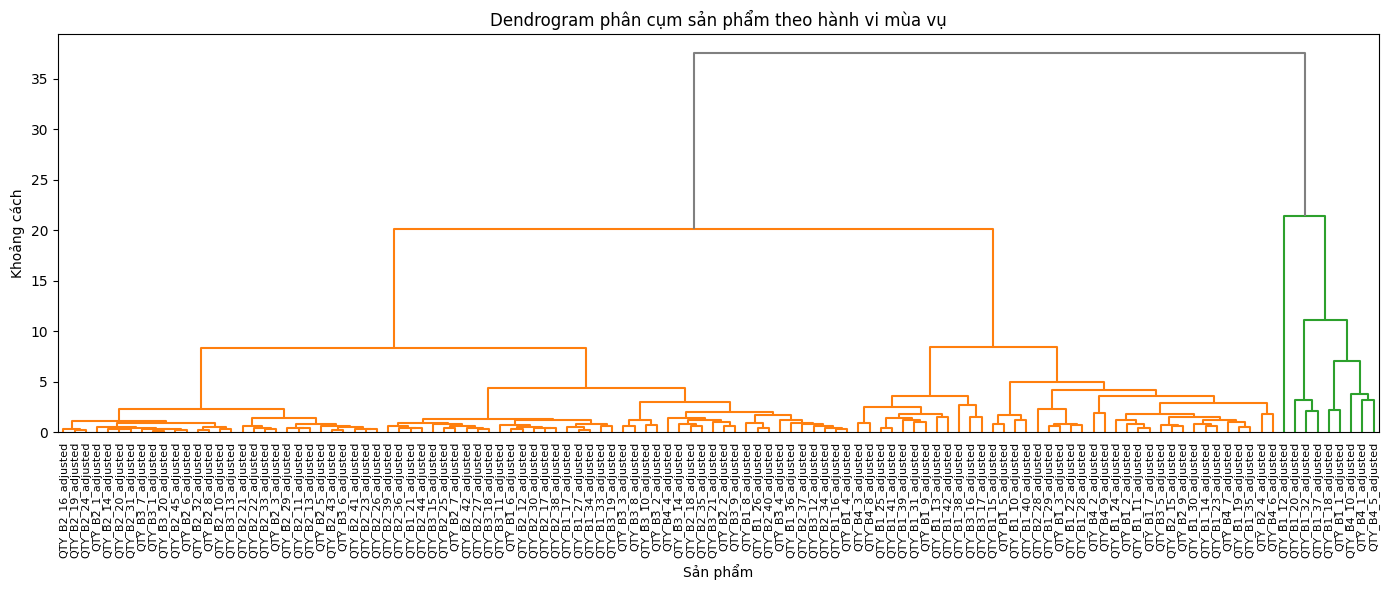

In [12]:
# Vẽ dendrogram
plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, labels=product_month_matrix.index, leaf_rotation=90, leaf_font_size=8, above_threshold_color='gray')
plt.title('Dendrogram phân cụm sản phẩm theo hành vi mùa vụ')
plt.xlabel('Sản phẩm')
plt.ylabel('Khoảng cách')
plt.tight_layout()
plt.show()
